In [1]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

import time
start_time = time.time()

In [2]:
from google.cloud import storage

In [3]:
%%time
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kishorkumarreddy/df_coords_final_df/')
df.count()

23/03/09 05:16:20 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 40.4 ms, sys: 7.99 ms, total: 48.4 ms
Wall time: 35.4 s


1005167

In [4]:
df.limit(5).toPandas()

,created_at,id,geo_coordinates,user_name,followers_count,verified_user,user_location,user_description,reply_count,retweet_count,retweeted_status,tweet_text,text
0,Sat Oct 29 18:36:18 +0000 2022,1586426715760459778,None,TitanUp Ty,2256,False,None,#LGM #TITANS #GBO🍊 #FJB #NJ #USA 🇺🇸,5,51,"(None, Sat Oct 29 13:22:46 +0000 2022, [0, 82]...",your current sec college football qbr leaders....,RT @JWPSports: Your current SEC College Footba...
1,Sat Oct 29 18:36:18 +0000 2022,1586426719090589696,None,SickYooo,88,False,None,..,3,168,"(None, Sun Feb 13 19:58:23 +0000 2022, [0, 140...",latina baddie wanted to suck me off during a p...,RT @pxrnstachee: Latina baddie wanted to suck ...
2,Sat Oct 29 18:36:55 +0000 2022,1586426871524343814,None,Saturn,883,False,America,#براندازم #نه_به_جمهوری_اسلامی,0,7,"(None, Sat Oct 29 18:23:54 +0000 2022, None, (...",today’s peaceful student protests of #universi...,RT @iranhr: Today’s peaceful student protests ...
3,Sat Oct 29 18:38:00 +0000 2022,1586427143302443008,None,💙KOHAKU225💙,127,False,"Baton Rouge, LA",None,3,16,"(None, Fri Oct 28 23:51:52 +0000 2022, [0, 140...",first 100 follows gets a surprise \nopen dms\n...,RT @freaky_central2: First 100 follows gets a ...
4,Sat Oct 29 18:38:43 +0000 2022,1586427325264310273,None,maoooo,6,False,None,None,2,10,"(None, Sat Oct 29 18:23:54 +0000 2022, None, (...",today’s peaceful student protests of #universi...,RT @iranhr: Today’s peaceful student protests ...


In [5]:
df.show()

+--------------------+-------------------+---------------+--------------------+---------------+-------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+--------------------+
|          created_at|                 id|geo_coordinates|           user_name|followers_count|verified_user|       user_location|    user_description|reply_count|retweet_count|    retweeted_status|          tweet_text|                text|
+--------------------+-------------------+---------------+--------------------+---------------+-------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+--------------------+
|Sat Oct 29 18:36:...|1586426715760459778|           null|          TitanUp Ty|           2256|        false|                null|#LGM #TITANS #GBO...|          5|           51|{null, Sat Oct 29...|your current sec ...|RT @JWPSports: Yo...|
|Sat Oct 29 18:36:...|15864267190905

In [6]:
#To get the original tweets, we filter the records where the retweet status is null
count_overall = df.count()
origina_tw_cnt = df.filter('retweeted_status is null').count()

In [7]:
print('Count of total tweets before filtering:', count_overall)
print('Count of the original tweets:', origina_tw_cnt)

Count of total tweets before filtering: 1005167
Count of the original tweets: 352608


# Most Prolific (Influential Tweeters) Using the Count of Original Tweets & Their Followers

In [8]:
original_tweet_data = df.filter("retweeted_status is null and verified_user == True")
print(type(original_tweet_data))
original_df = original_tweet_data.groupby("user_name").agg(F.count('*').alias('count_of_tweets'))\
                         .select(['user_name','count_of_tweets'])\
                         .orderBy('count_of_tweets', ascending = False).limit(20).toPandas()

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
original_df

,user_name,count_of_tweets
0,The Highland Council,284
1,Brendan Schneider,164
2,The Tribune,132
3,News Ghana,115
4,Rising Kashmir,115
5,"NASN, Inc.",110
6,Free Press Journal,110
7,CapricornFM News,107
8,India.com,95
9,DNA,72


In [10]:
prolific_twitterers = list(original_df['user_name'].values)
fil_str = "user_name == '" + prolific_twitterers[0] + "'"
for i in prolific_twitterers[1:]:
    fil_str += (" or user_name == '" + i + "'")
    
fam_tws = original_tweet_data.filter(fil_str)
fam_tws.count()

1870

In [11]:
#We now have the data to extract the prolific tweeters based on how many times their tweets have been retweeted
fam_tws_pd = fam_tws.toPandas()
fam_tws_pd.head()

,created_at,id,geo_coordinates,user_name,followers_count,verified_user,user_location,user_description,reply_count,retweet_count,retweeted_status,tweet_text,text
0,Sun Sep 18 04:36:06 +0000 2022,1571357370151845888,None,India.com,28508,True,India,Follow http://india.com for breaking news from...,NaN,NaN,None,massive protests emerge in #chandigarhuniversi...,Massive protests emerge in #chandigarhuniversi...
1,Wed Feb 01 08:40:21 +0000 2023,1620703591039385601,None,National Education Union,88592,True,United Kingdom,The National Education Union represents the ma...,NaN,NaN,None,according to @mumsnettowers the majority of pa...,According to @MumsnetTowers the majority of pa...
2,Tue Jan 03 13:28:01 +0000 2023,1610266733780283398,None,India.com,28984,True,India,Follow http://india.com for breaking news from...,NaN,NaN,None,#schoolclosingnews | jharkhand declares school...,#SchoolClosingNews | Jharkhand Declares School...
3,Tue Aug 23 17:43:03 +0000 2022,1562133328257499136,None,"NASN, Inc.",10200,True,"Silver Spring, Maryland, USA",The mission of the National Association of Sch...,NaN,NaN,None,"check out this opinion piece @donnamazyck, nas...","Check out this opinion piece @DonnaMazyck, NAS..."
4,Tue Aug 23 17:45:01 +0000 2022,1562133825584599040,None,EdSurge,160563,True,"Portland, OR","EdSurge covers and connects the people, ideas ...",NaN,NaN,None,a new study shows digital systems report stude...,A new study shows digital systems report stude...


In [12]:
fam_tws_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   created_at        1870 non-null   object 
 1   id                1870 non-null   int64  
 2   geo_coordinates   0 non-null      object 
 3   user_name         1870 non-null   object 
 4   followers_count   1870 non-null   int64  
 5   verified_user     1870 non-null   bool   
 6   user_location     1804 non-null   object 
 7   user_description  1870 non-null   object 
 8   reply_count       0 non-null      float64
 9   retweet_count     0 non-null      float64
 10  retweeted_status  0 non-null      object 
 11  tweet_text        1870 non-null   object 
 12  text              1870 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 177.3+ KB


In [13]:
fam_tws.createOrReplaceTempView("fam_tws")

In [14]:
#We can select the required fields to get the prolific users
#twt_text_info = fam_tws_pd[['user_name','text', 'tweet_text']]
#twt_text_info.head()

query_txt_info = '''
select user_name,
count(text) as number_of_tweets,
sum(followers_count) as followers_count
from fam_tws
group by user_name
order by followers_count desc'''
txt_info = spark.sql(query_txt_info)

In [15]:
#We can see that the tweets are original
txt_info.show(10)

+--------------------+----------------+---------------+
|           user_name|number_of_tweets|followers_count|
+--------------------+----------------+---------------+
|           TIMES NOW|              68|      698318444|
|                 DNA|              72|      164936270|
|      Rising Kashmir|             115|       25537739|
| U.S. News Education|              67|       22136817|
|         The Tribune|             132|       21082137|
|             EdSurge|              54|        8650484|
|The Highland Council|             284|        8519086|
|          Mirror Now|              52|        6023266|
|    CapricornFM News|             107|        5002078|
|          News Ghana|             115|        4550812|
+--------------------+----------------+---------------+
only showing top 10 rows



# Prolific/ Most Influential Twitterers based on the times their tweets have been retweeted

In [16]:
rtwt_df = df.filter("retweeted_status is not null")

In [17]:
rtwt_df.show()
rtwt_df = rtwt_df.withColumn("tweet_text", F.lower(F.col("tweet_text")))\
                            .select(['text', 'tweet_text', 'retweet_count', 'user_name','retweeted_status'])\
                            .groupby(['user_name'])\
                            .agg((avg('retweet_count')).alias('average_retweets_per_tweet')).toPandas()

+--------------------+-------------------+---------------+--------------------+---------------+-------------+----------------+--------------------+-----------+-------------+--------------------+--------------------+--------------------+
|          created_at|                 id|geo_coordinates|           user_name|followers_count|verified_user|   user_location|    user_description|reply_count|retweet_count|    retweeted_status|          tweet_text|                text|
+--------------------+-------------------+---------------+--------------------+---------------+-------------+----------------+--------------------+-----------+-------------+--------------------+--------------------+--------------------+
|Sat Oct 29 18:36:...|1586426715760459778|           null|          TitanUp Ty|           2256|        false|            null|#LGM #TITANS #GBO...|          5|           51|{null, Sat Oct 29...|your current sec ...|RT @JWPSports: Yo...|
|Sat Oct 29 18:36:...|1586426719090589696|          

In [18]:
tw_users_t = original_df

In [19]:
display(tw_users_t.sort_values(by = 'count_of_tweets', ascending = False).head())
display(len(tw_users_t))

,user_name,count_of_tweets
0,The Highland Council,284
1,Brendan Schneider,164
2,The Tribune,132
3,News Ghana,115
4,Rising Kashmir,115


20

In [20]:
display(rtwt_df.sort_values(by = 'average_retweets_per_tweet', ascending = False).head())
display(len(tw_users_t))

,user_name,average_retweets_per_tweet
127425,The Mablest of Donkeys,110384.0
275927,"🇺🇦 Mike Mozart, 🎨 Pop Artist MiMo",110382.0
95686,김윌셔,110200.0
106537,Abraham Akuei,110168.0
218737,Valerie Sielert,110090.0


20

In [21]:
#Now based on the count of tweets and their average retweets, we can merge the above dfs and get the order of prolific tweets based on retweets
rt_users_t = pd.merge(left = tw_users_t, right = rtwt_df, left_on = 'user_name', right_on = 'user_name', how = 'left')

In [22]:
rt_users_t[['user_name', 'count_of_tweets','average_retweets_per_tweet']].sort_values(by = 'average_retweets_per_tweet', ascending = False).head(10)

,user_name,count_of_tweets,average_retweets_per_tweet
18,Lori Lite,49,6.294118
19,National Education Union,45,4.000000
1,Brendan Schneider,164,3.200000
10,TIMES NOW,68,2.000000
14,Montgomery College,57,1.428571
5,"NASN, Inc.",110,1.142857
2,The Tribune,132,1.000000
3,News Ghana,115,1.000000
6,Free Press Journal,110,1.000000
9,DNA,72,1.000000


In [23]:
#rt_users_t[['user_name', 'count_of_tweets','average_retweets_per_tweet']].sort_values(by = 'average_retweets_per_tweet', ascending = False).head(10)
s_rt_users_t = spark.createDataFrame(rt_users_t)
s_rt_users_t.createOrReplaceTempView("s_rt_users_t")

In [24]:
query = '''
select user_name, 
round((count_of_tweets*average_retweets_per_tweet),2) as tweet_rt_rate
from s_rt_users_t
where round((count_of_tweets*average_retweets_per_tweet),2)>=0
order by tweet_rt_rate desc'''
tw_qy = spark.sql(query)
tw_qy = tw_qy.dropna()

In [25]:
#The tweet rate calculated here is based on the count of tweets and average retweets per tweet
tw_qy.show()

+--------------------+-------------+
|           user_name|tweet_rt_rate|
+--------------------+-------------+
|   Brendan Schneider|        524.8|
|           Lori Lite|       308.41|
|National Educatio...|        180.0|
|           TIMES NOW|        136.0|
|         The Tribune|        132.0|
|          NASN, Inc.|       125.71|
|          News Ghana|        115.0|
|  Free Press Journal|        110.0|
|  Montgomery College|        81.43|
|                 DNA|         72.0|
|       ThePapare.com|         50.0|
+--------------------+-------------+



# Who are these Twitterers(government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [26]:
### To find this out, we can group the users the users by using their descriptions
#!break!

In [27]:
entity_extraction = df.select(['user_name', 'user_description', 'followers_count', 'id'])

In [28]:
df.select(['user_name', 'user_description']).limit(40).toPandas()

,user_name,user_description
0,TitanUp Ty,#LGM #TITANS #GBO🍊 #FJB #NJ #USA 🇺🇸
1,SickYooo,..
2,Saturn,#براندازم #نه_به_جمهوری_اسلامی
3,💙KOHAKU225💙,None
4,maoooo,None
5,Hashtag,Virtual University Student
6,Shehr Bano,None
7,Parent Security,#Parents who want to keep their #children #saf...
8,Get That Right,Helping You Know Things Better
9,Alex Bellars ☮️🇺🇦🇪🇺🏴󠁧󠁢󠁷󠁬󠁳󠁿,"Born 327.34 CO2 ppm/Fre, Ger, Hist & PE teache..."


In [29]:
%%time

@F.udf
def get_entity_twt(user_description, followers_count, user_name):
    if (followers_count < 500):
        return "Misc"
    
    if(user_description == None or user_name == None):
        return "Influencer"
    user_name = user_name.lower()
    user_description = user_description.lower()
    
    if('school' in user_name or 'school' in user_description or 'university' in user_name or 'university' in user_description
      or 'professor' in user_name or 'professor' in user_description or 'research' in user_name or 'research' in user_description
        or 'classroom' in user_name or 'classroom' in user_description):
        return "School and Universities"
    
    elif('non profit' in user_name or 'non profit' in user_description  or 'ngo' in user_name or 'ngo' in user_description 
       or 'donate' in user_description or 'donate' in user_name):
        return "Nonprofit Organizations"
    
    elif('gov' in user_description or 'gov' in user_name or 'Department of' in user_name or 'Department of' in user_description
      or 'president' in user_description or 'president' in user_name or 'senate' in user_description or 'senate' in user_name
      or 'gop' in user_description or 'gop' in user_name or 'mayor' in user_description or 'mayor' in user_name
      or 'democ' in user_description or 'democ' in user_name or 'republ' in user_description or 'republ' in user_name
      or 'white house' in user_description or 'white house' in user_name or 'speaker' in user_description or 'speaker' in user_name
      or 'parliament' in user_description or 'parliament' in user_name or 'congress' in user_description or 'congress' in user_name
      or 'minister' in user_description or 'minister' in user_name or 'law' in user_description or 'law' in user_name
      or 'republicans' in user_description or 'republicans' in user_name or 'republicans' in user_description or 'republicans' in user_name
      or 'democratics' in user_description or 'democratics' in user_name or 'democratics' in user_description or 'democratics' in user_name):
        return "Government"
    
    elif('news' in user_description or 'news' in user_name or 'journalist' in user_description or 'journalist' in user_name
      or 'daily' in user_description or 'daily' in user_name or 'journal' in user_description or 'journal' in user_name
      or 'times' in user_description or 'times' in user_name or 'post' in user_description or 'post' in user_name
      or 'bbc' in user_description or 'bbc' in user_name or 'fox' in user_description or 'fox' in user_name
      or 'abc' in user_description or 'abc' in user_name or 'nbc' in user_description or 'nbc' in user_name
      or 'msnbc' in user_description or 'msnbc' in user_name or 'cnbc' in user_description or 'cnbc' in user_name
      or 'ndtv' in user_description or 'ndtv' in user_name or 'editor' in user_description or 'editor' in user_name
      or 'host' in user_description or 'host' in user_name or 'writer' in user_description or 'writer' in user_name
      or 'report' in user_description or 'report' in user_name or 'truth' in user_description or 'truth' in user_name
      or 'media' in user_description or 'media' in user_name or 'paper' in user_description or 'paper' in user_name):
        return "News"
    
    else:
        return "Influencer"
     
entity_retr = df.withColumn("entity", get_entity_twt("user_description", "followers_count", "user_name"))

CPU times: user 6.56 ms, sys: 2.93 ms, total: 9.49 ms
Wall time: 88.4 ms


In [54]:
%%time
entity_analysis = entity_retr.select(['user_name', 'user_description', 'entity', 'id']).groupby('entity').agg(count('id')).toPandas()
pd.set_option('display.max_colwidth', 1000)
entity_retr.select(['user_name', 'user_description', 'entity']).limit(30).toPandas()

CPU times: user 55.5 ms, sys: 10.3 ms, total: 65.8 ms
Wall time: 23.8 s


,user_name,user_description,entity
0,TitanUp Ty,#LGM #TITANS #GBO🍊 #FJB #NJ #USA 🇺🇸,Influencer
1,SickYooo,..,Misc
2,Saturn,#براندازم #نه_به_جمهوری_اسلامی,Influencer
3,💙KOHAKU225💙,None,Misc
4,maoooo,None,Misc
5,Hashtag,Virtual University Student,Misc
6,Shehr Bano,None,Misc
7,Parent Security,#Parents who want to keep their #children #safe #Read #ParentSecurity. #teens #kids #schoolshooting #schoolsafety,Misc
8,Get That Right,Helping You Know Things Better,Influencer
9,Alex Bellars ☮️🇺🇦🇪🇺🏴󠁧󠁢󠁷󠁬󠁳󠁿,"Born 327.34 CO2 ppm/Fre, Ger, Hist & PE teacher/MCCT/hockeyist/painter/cyclist/sailor/actor/@TheGreenParty member/#RejoinEU/#campED/#antigrowthcoalition",Influencer


In [56]:
entity_retr.groupby('entity').agg(first('user_name'), first('user_description')).toPandas()

,entity,first(user_name),first(user_description)
0,Nonprofit Organizations,Gringo's Tex Mex,"The official account for Gringo's Tex-Mex. 🌮 Home of sizzling fajitas, cadillac 'ritas, & our famous creamy green sauce!"
1,Government,Sambucca Fellagirl🇨🇦(🇬🇧+🇺🇦),1st gen Canadian who stands with Ukraine for freedom & democracy! Dog lover. If you are RU or MagaT you will be blocked! #IStandWithUkraine #NAFO
2,Influencer,L'Agenda Girondin,"#sorties, #expositions, #spectacles, #animations #concerts dans les #communes environnantes ? #Bordeaux #Mérignac #Talence #Pessac #Cenon #Gironde"
3,School and Universities,Maile School,"Maile School is the top rated training facility for image, modeling and acting in Central Florida! Training since 1982."
4,Misc,asdadwa,None
5,News,𝐏𝐎𝐑𝐍 𝐗𝐓𝐘,"We Don't Own Any Content Posted.\n\n©️😍📥\n\n ⚠️⚠️If you'll waste my time, I'm gonna block you permanently⚠️⚠️\nBackup @haleyvids"


,entity,count(id)
4,Misc,627690
2,Influencer,243752
3,School and Universities,60553
5,News,48988
1,Government,22133
0,Nonprofit Organizations,2051


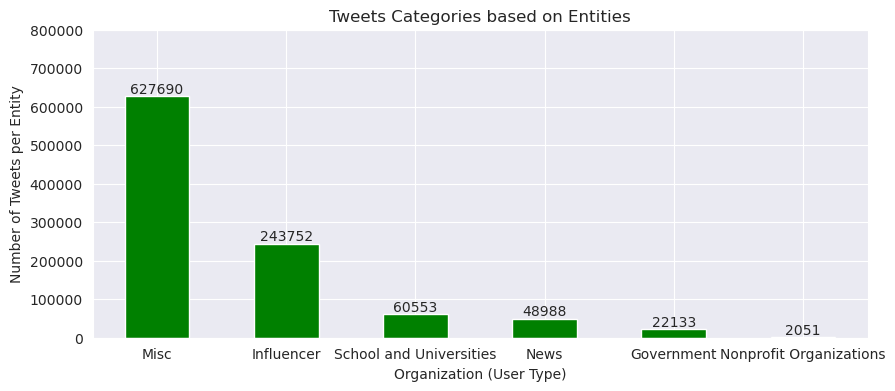

In [50]:
import seaborn as sns
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (10, 4)
entity_analysis.sort_values(by='count(id)', inplace=True, ascending=False)
display(entity_analysis)
fig = entity_analysis.plot(kind='bar', x='entity', y='count(id)', legend=None, color='green', grid=True)
fig.set_xlabel('Organization (User Type)')
fig.set_ylabel('Number of Tweets per Entity')
fig.bar_label(fig.containers[0], fmt='%d', label_type='edge')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.title('Tweets Categories based on Entities')
plt.ylim([-0.5, 800000])
plt.show()

In [33]:
%%time 
try:
    entity_extraction.write.\
                                parquet("gs://msca-bdp-students-bucket/shared_data/kishorkumarreddy/df_final_for_analysis")
except:
    pass

clear_output(wait = False)

CPU times: user 2.44 ms, sys: 3.71 ms, total: 6.15 ms
Wall time: 137 ms


In [44]:
entity_analysis.head()

,entity,count(id)
4,Misc,627690
2,Influencer,243752
3,School and Universities,60553
5,News,48988
1,Government,22133


In [52]:
entity_extraction.show(10)

+--------------------+--------------------+---------------+-------------------+
|           user_name|    user_description|followers_count|                 id|
+--------------------+--------------------+---------------+-------------------+
|          TitanUp Ty|#LGM #TITANS #GBO...|           2256|1586426715760459778|
|            SickYooo|                  ..|             88|1586426719090589696|
|              Saturn|#براندازم #نه_به_...|            883|1586426871524343814|
|       💙KOHAKU225💙|                null|            127|1586427143302443008|
|              maoooo|                null|              6|1586427325264310273|
|             Hashtag|Virtual Universit...|              4|1586427331161518080|
|          Shehr Bano|                null|             22|1586427333426061312|
|     Parent Security|#Parents who want...|            286|1586427341244231681|
|      Get That Right|Helping You Know ...|            802|1586427362228436996|
|Alex Bellars ☮️🇺...|Born 327.34 CO2 p...|

In [60]:
from pyspark.sql.functions import mean


entity_analysis_retweet = entity_retr.groupby('entity').agg(avg('retweet_count')).toPandas()
entity_analysis_retweet

,entity,avg(retweet_count)
0,Nonprofit Organizations,194.759275
1,Government,132.577677
2,Influencer,263.999616
3,School and Universities,43.944721
4,Misc,422.234625
5,News,150.282228


,entity,avg(retweet_count)
0,Nonprofit Organizations,194.759275
1,Government,132.577677
2,Influencer,263.999616
3,School and Universities,43.944721
4,Misc,422.234625
5,News,150.282228


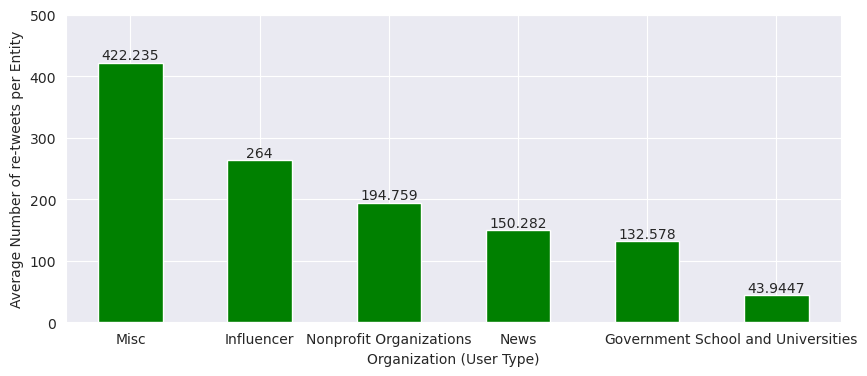

In [61]:
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("dark")
display(entity_analysis_retweet)
entity_analysis_retweet.sort_values(by='avg(retweet_count)', inplace=True, ascending=False)
fig = entity_analysis_retweet.plot(kind='bar', x='entity', y='avg(retweet_count)', legend=None, color='green', grid=True)
fig.set_xlabel('Organization (User Type)')
fig.set_ylabel('Average Number of re-tweets per Entity')
fig.bar_label(fig.containers[0], label_type='edge')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.ylim([-0.5, 500])
plt.show()


,entity,avg(retweet_count)
4,Misc,422.234625
2,Influencer,263.999616
0,Nonprofit Organizations,194.759275
5,News,150.282228
1,Government,132.577677
3,School and Universities,43.944721


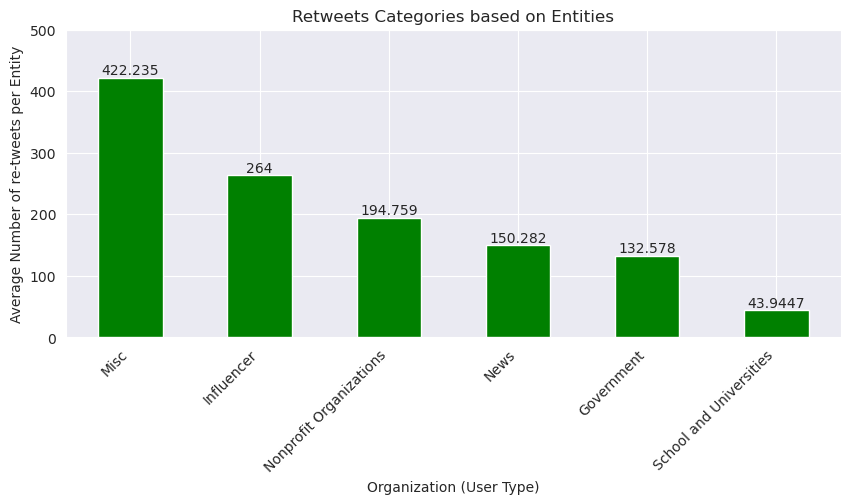

In [64]:
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("dark")
display(entity_analysis_retweet)
entity_analysis_retweet.sort_values(by='avg(retweet_count)', inplace=True, ascending=False)
fig = entity_analysis_retweet.plot(kind='bar', x='entity', y='avg(retweet_count)', legend=None, color='green', grid=True)
fig.set_xlabel('Organization (User Type)')
fig.set_ylabel('Average Number of re-tweets per Entity')
fig.bar_label(fig.containers[0], label_type='edge')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
plt.title('Retweets Categories based on Entities')
plt.ylim([-0.5, 500])
plt.show()